# IKpy Quickstart #

Import the IKPy module : 

In [1]:
import ikpy.chain
import numpy as np
import math
import random
import scipy
import ikpy.utils.plot as plot_utils

The basic element of IKPy is the kinematic `Chain`.
To create a chain from an URDF file : 

In [2]:
my_chain = ikpy.chain.Chain.from_urdf_file("./ur5/ur5_gripper.urdf")

/home/Parker/Programming/Robotics/lab-2-ik/.pixi/envs/default/lib/python3.12/site-packages/ikpy/chain.py:60: UserWarning: Link Base link (index: 0) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive".format(link.name, link_index))
/home/Parker/Programming/Robotics/lab-2-ik/.pixi/envs/default/lib/python3.12/site-packages/ikpy/chain.py:60: UserWarning: Link ee_fixed_joint (index: 7) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is a

# Inverse kinematics

In Inverse Kinematics, you want your kinematic chain to reach a 3D position in space.

To have a more general representation of position, IKPy works with homogeneous coordinates. Homogenous coordinates are represented as a 4x4 matrix storing both position and orientation. Here we only consider (x,y,z) position, not orientation of the chain.

In [3]:
target_position = [ 0, 0, 0]

In [4]:
print("The joint angles are : ", my_chain.inverse_kinematics(target_position))

The joint angles are :  [ 0.         -0.74401548 -0.11919084  2.75181748 -0.48576036  3.1398436
  0.          0.        ]


You can check that the Inverse Kinematics is correct by comparing with the original position vector : 

In [5]:
real_frame = my_chain.forward_kinematics(my_chain.inverse_kinematics(target_position))
print("Computed position vector : %s, goal position vector : %s" % (real_frame[:3, 3], target_position))

Computed position vector : [ 1.81841962e-02  1.97551074e-02 -8.73542152e-10], goal position vector : [0, 0, 0]


# Plotting
And finally plot the result. We also include a convex hull for the points reachable by the robot generated by sampling points on a sphere larger than its reach: 

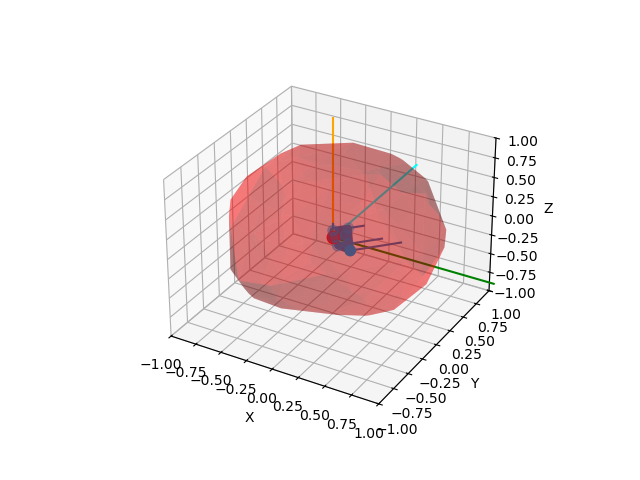

In [6]:
%matplotlib notebook
%matplotlib ipympl

import matplotlib.pyplot as plt


fig, ax = plot_utils.init_3d_figure()
my_chain.plot(my_chain.inverse_kinematics(target_position), ax, target=target_position)

# Inverse Transform Sampling
def sample_sphere_surface():
    phi = random.uniform(0, 2*math.pi)
    # Used to counteract the jacobian factor for spherical point selection. Corresponds with theta/pitch.
    u = random.random()
    z = 1-(2*u)
    rad = math.sqrt(1-(z**2))
    x = rad * math.cos(phi)
    y = rad * math.sin(phi)
    return [x, y, z]

# Returns a list containing n entries of sampled arm positions when trying to reach uniformly distributed points on a sphere.
def sample_reach(n):
    samples = []
    for i in range(n):
        sampled_point = sample_sphere_surface()
        reached_point = my_chain.forward_kinematics(my_chain.inverse_kinematics(sampled_point))[:3, 3]
        samples.append(reached_point)
    return samples
    

# Create a convex hull of the robot's reach and display it on the plot.
samples = 100
furthest_reached_points = np.array(sample_reach(samples))
hull = scipy.spatial.ConvexHull(furthest_reached_points)
for simplex in hull.simplices:
    tri = furthest_reached_points[simplex]
    ax.plot_trisurf(tri[:,0], tri[:,1], tri[:,2], color="red", alpha=0.3)


False


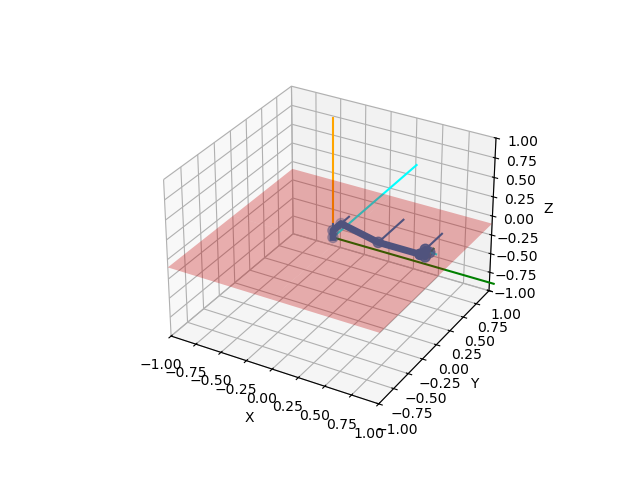

In [7]:
%matplotlib notebook
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

zero_config = [0] * len(my_chain.links)
fig, ax = plot_utils.init_3d_figure()


# PART 3: Collision checking
# Draw the robot and a plane and detect if the robot is colliding with it.
def is_colliding(arm_config, plane_point, plane_norm):
    # Plot the current robot arm configuration, and then draw the plane.
    my_chain.plot(arm_config, ax)
    
    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate d then we can create our plane.
    d = -plane_point.dot(plane_norm)
    
    # create x,y
    xx, yy = np.meshgrid(range(-1,2), range(-1,2))
    
    # calculate corresponding z
    z = (-plane_norm[0] * xx - plane_norm[1] * yy - d) * 1. /plane_norm[2]
    ax.plot_surface(xx, yy, z, color="red", alpha=0.3)

    rotation_matrices = my_chain.forward_kinematics(arm_config, full_kinematics=True)
    
    # The position of each joint is stored in the first three elements of the 4th row.
    joint_positions = [m[:3, 3] for m in rotation_matrices]
    
    # Solve line-plane collision by using point-normal form of a plane.
    for i in range(len(my_chain.links)-1):
        va = joint_positions[i] - plane_point
        vb = joint_positions[i+1] - plane_point

        da = va.dot(plane_norm)
        db = vb.dot(plane_norm)
        if ((da < 0) != (db < 0)):
            return True
    return False

# Test case 1: A normal plane. With the robot at the zero position, the robot doesn't intersect this plane.
print(is_colliding(zero_config, np.array([0,0,-0.1]), np.array([0,0,1])))

True


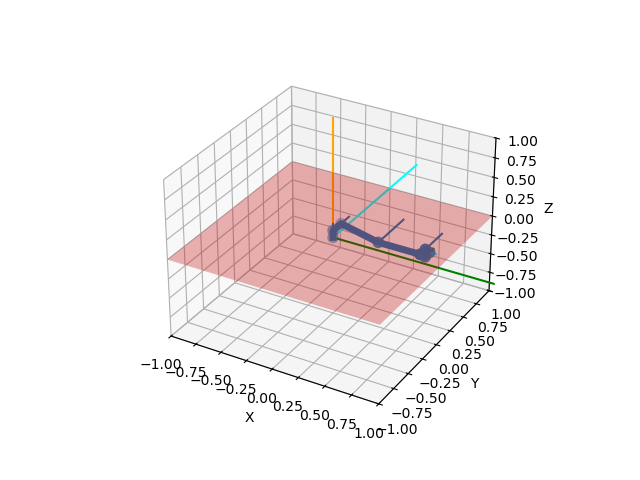

In [8]:
# Test case 2: The plane is raised slightly higher. The last 2 wrists cross into the plane.
fig, ax = plot_utils.init_3d_figure()
print(is_colliding(zero_config, np.array([0,0,0]), np.array([0,0,1])))

True


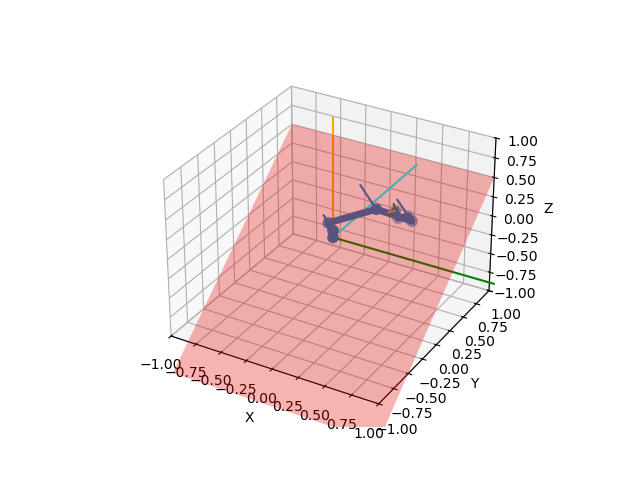

In [11]:
# Test case 3: The plane is slightly more complex and the arm is reaching around nearby.
# The end-effector is on the correct side of the plane but the wrists barely cross the plane.
fig, ax = plot_utils.init_3d_figure()
target = [0.3, 0.55, 0.1]
arm_config = my_chain.inverse_kinematics(target)
print(is_colliding(arm_config, np.array([0,1,0.5]), np.array([0,1,-1])))